# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: session overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [2]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## Preprocess the data & Fit the model 

Like we previously did lets make data consistent (with gaps and lowercase), fix total charges, fix the total charges that has - and creates errors, put NaN there and then fill NaN, finally fix target variable churn

In [15]:
df = pd.read_csv('data-week-3.csv')
df.head(5)

df.columns = df.columns.str.lower().str.replace(' ', '_') 

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    
    df[c] = df[c].str.lower().str.replace(' ', '_') 
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [16]:
df_full_train , df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [26]:
list(df_train.dtypes[(df_train.dtypes == float)].index)

['monthlycharges', 'totalcharges']

In [35]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [36]:
dv = DictVectorizer(sparse = False)

train_dict = df_train[categorical + numerical].to_dict(orient = 'records')

X_train = dv.fit_transform(train_dict)

model = LogisticRegression()

model.fit(X_train, y_train)

/home/giorgos/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [40]:
val_dict = df_val[categorical + numerical].to_dict(orient = 'records')

X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1] # we only care about the second column thats churning

churn_decision = (y_pred >= 0.5)

(y_val == churn_decision).mean()

0.8026969481902059

## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [41]:
len(y_val)

1409

How many decisions are correct ?

In [43]:
(y_val == churn_decision).sum() / len(y_val)

0.8026969481902059

We got this accuracy by using a 0.5 threshold to flag churn based on probabilities, is that though a good value? We can actually try and test this!

In [50]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    
    churn_decision = (y_pred >= t)

    score = (y_val == churn_decision).mean()
    
    print('%.2f %.3f' % (t, score))
    scores.append(score)
    

0.00 0.274
0.05 0.510
0.10 0.592
0.15 0.667
0.20 0.710
0.25 0.738
0.30 0.759
0.35 0.773
0.40 0.785
0.45 0.795
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


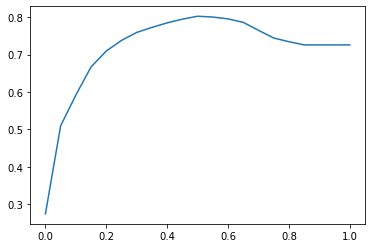

In [47]:
plt.plot(thresholds, scores)

So 0.5 is indeed the best threshold! Seen in the graph and from the results 

We can use scikit-learn function instead of doing it ourselves

In [52]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred >= 0.5)

0.8026969481902059

Intersting to see the last and first values, if threshold is above or eq. 1.0, it means that we practically supposes every customer is not churning all the time, all customers stay, and it has a 73% accuracy

In [56]:
from collections import Counter

In [57]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

So if this dummy model scores 7% less than the best, why bother ? Thats the accuracy limitation, lets look at the distribution of y_val to understand.

In [58]:
Counter(y_val)

Counter({0: 1023, 1: 386})

There are a lot more that are not churning, the prob in this set of not churning is also similar to the accuracy of the DUMMY model

In [60]:
(1 - y_val.mean())

0.7260468417317246

## 4.3 Confusion Table

- Different types of errors and correct decisions
- Arranging them in a table

    - True Positives
    - True Negatives
    - False Positives
    - False Negatives

In [61]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [62]:
t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

Check the true positives and true negatives !

In [63]:
tp = (predict_positive & actual_positive ).sum()
tn = (predict_negative & actual_negative).sum()

In [65]:
tn

921

In [66]:
fp = (predict_positive & actual_negative ).sum()
fn = (predict_negative & actual_positive).sum()

In [68]:
fn

176

In [69]:
len(y_val)

1409

In [71]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[921, 102],
       [176, 210]])

We have lot more false negatives than false positives, so its more often that we predict a customer will stay and they leave and this has a big impact since customers leave

and ofc a lot of true negatives correct predictions that people will stay

In [72]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision & Recall

In [74]:
(tp + tn)/(tp + tn + fp + fn) # this is accuracy

0.8026969481902059

**Precision formula**

In [75]:
p = tp / (tp + fp)

p

0.6730769230769231

This means that only 67% of the people who will receive a promotion with a discount to motivate them to stay were actually going to leave

**Recall formula**

In [76]:
r = tp / (tp + fn)

r

0.5440414507772021

So this means that for 46% of people who are churning we fail to identify, or we identified only 54% of the people who are actually leaving

**Overall:**
    Looking at accuracy of 80% we could think that our model was performing well, but accuracy is misleading if we take into account precision and recall which is what matters for our model!!

## 4.5 ROC Curves

Receiver operator characteristics, used in WW2 for evaluating the strength of radar detectors

- True positive rate
- False positive rate

### TPR and FRP

In [77]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [80]:
r

0.5440414507772021

In [79]:
fpr = fp / (tn + fp)
fpr

0.09970674486803519

So we notice tpr is the same as recall! From fpr we see that ~10% of positives are incorrect

But we evaluated all these for only one threshold, 0.5 in this case, the ROC curves look at all possible thresholds

In [89]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive ).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative ).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn)) # append the tuple

So we kinda end up with 101 confusion matrices

In [90]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)

In [91]:
df_scores[::10] # look at each 10th record, from first to last moving with increments of 10

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,555,20,468
20,0.2,333,356,53,667
30,0.3,284,237,102,786
40,0.4,249,166,137,857
50,0.5,210,102,176,921
60,0.6,151,53,235,970
70,0.7,75,20,311,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [92]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)

Note remember to use this notation df_scores['fpr'] or we will get a warning

In [93]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,555,20,468,0.948187,0.542522
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,237,102,786,0.735751,0.231672
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,102,176,921,0.544041,0.099707
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,75,20,311,1003,0.194301,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


Text(0.5, 0, 'Threshold')

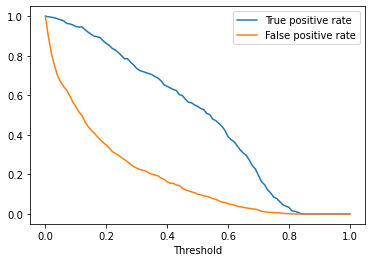

In [109]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'True positive rate')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'False positive rate')

plt.legend()

plt.xlabel('Threshold')

For threshold 0 both rates are 1, this is a dummy model, all customers are identified as churning so all positives are correct and all negatives are false positives since we also flag them as positives

## Random model

We need a baseline model for comparison

like a coin flip model, customer churning/no churning full random

In [110]:
np.random.seed(1)

y_rand = np.random.uniform(0, 1, size = len(y_val))

In [111]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

Lets create a function that creates the rates dataframe

In [112]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:

        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive ).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative ).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn)) # append the tuple
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)
    
    return df_scores

In [113]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [114]:
df_rand

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,382,1013,4,10,0.989637,0.990225
2,0.02,379,993,7,30,0.981865,0.970674
3,0.03,375,979,11,44,0.971503,0.956989
4,0.04,372,969,14,54,0.963731,0.947214
...,...,...,...,...,...,...,...
96,0.96,14,41,372,982,0.036269,0.040078
97,0.97,11,36,375,987,0.028497,0.035191
98,0.98,8,19,378,1004,0.020725,0.018573
99,0.99,6,7,380,1016,0.015544,0.006843


Text(0.5, 0, 'Threshold')

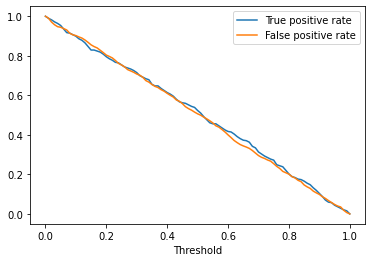

In [115]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'True positive rate')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'False positive rate')

plt.legend()

plt.xlabel('Threshold')

## Ideal model

In [116]:
num_neg = (y_val == 0).sum()
num_pos = (y_val ==1).sum()

num_neg, num_pos

(1023, 386)

So we see the number of actual positive and negative examples

We will create an array based on these numbers which are basically the predictions, using the repeat function of numpy, and we will repeat the number of 0 and number of ones as in y_val

In [117]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [118]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [127]:
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [122]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [123]:
1 - y_ideal.mean() # we calculate this to use it as the ratio

0.7260468417317246

In [124]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

Text(0.5, 0, 'Threshold')

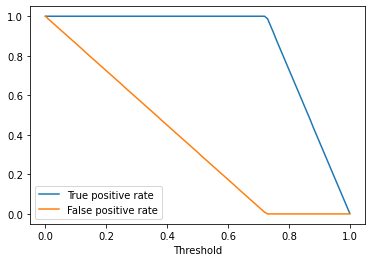

In [126]:
df_ideal[::10]

plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'True positive rate')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'False positive rate')

plt.legend()

plt.xlabel('Threshold')

In this case **True positive** always stays at 1 except after the 0.726 threshold thats the rate of not churning in the dataset, if we further increase it then we take into account as negative (non churning) examples that are actually churning, so there are more false negatives. Below the threshold it always predicts correctly the customers that are churning and thats why its 1.

For **False Positive** its the oposite after the threshold we identify all negatives correctly so there are no false positives, but below it we identify some negatives as positives, so some people are not churning but we predict that they are.

## Putting everything together

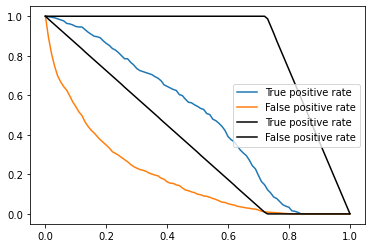

In [131]:

plt.plot(df_scores.threshold, df_scores['tpr'], label = 'True positive rate')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'False positive rate')


# plt.plot(df_rand.threshold, df_rand['tpr'], label = 'True positive rate')
# plt.plot(df_rand.threshold, df_rand['fpr'], label = 'False positive rate')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'True positive rate', color = 'black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'False positive rate', color = 'black')

plt.legend()

We want our model to be as close as possible to the ideal, but its far apart both for FPR and TPR. 

Plotting against the threshold isn't always intuititive, remember our model has 0.5 as best threshold and the ideal has 0.726

So lets plot false positive rate against true positive 

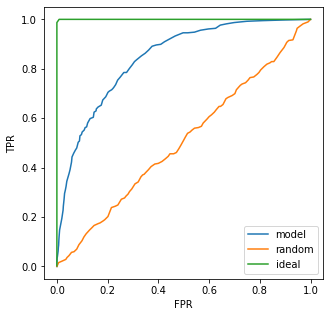

In [135]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label = 'model')
plt.plot(df_rand.fpr, df_rand.tpr, label = 'random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

Fluctuations for the random are only due to randomness sometimes it behaves better, sometimes worse

We want to basically reach the point where TPR is 1 and FPR is 0 this is the ideal point, that we dont make any mistakes. An actual ROC curve does not have the ideal model (we can think of it mostly as the ideal point in the right triangle , and the random is basically a line from 0 to 1

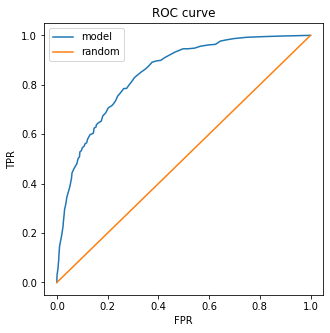

In [140]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label = 'model')
plt.plot([0,1], [0,1], label = 'random')

plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [141]:
from sklearn.metrics import roc_curve

In [143]:
fpr, tpr, tresholds = roc_curve(y_val, y_pred)

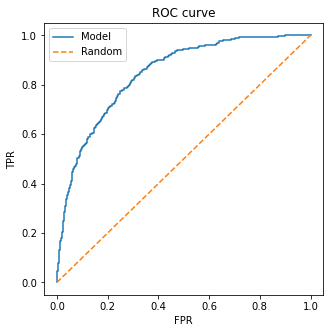

In [146]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label = 'Model')
plt.plot([0,1], [0,1], label = 'Random', linestyle = '--')

plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

Model curve looks a bit more bumpy since scikitlearn calculates more thresholds and its more accurate

## AUC-Area under the curve

A useful metric is the area under the curve to see how close we are to the ideal model, we can use from sklearn the auc, which calculates the area under **any** curve

In [149]:
from sklearn.metrics import auc

In [150]:
auc(fpr, tpr)

0.843761870755018

In [151]:
auc(df_scores.fpr, df_scores.tpr) # the frp/tpr we calculated which are a bit less accurate

0.8438378435871333

In [152]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

And we can straigt away compute the auc metric from y

In [153]:
from sklearn.metrics import roc_auc_score

In [154]:
roc_auc_score(y_val, y_pred)

0.843761870755018

**AUC** is basically the **probability** that a randomly selected **positive example** has a **higher score** than a randomly selected **negative example**.

We can check this:

In [157]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val ==1]

In [158]:
import random

In [167]:
n = 10000
success = 0

for i in range(n):
    
    # in randint both limits are inclusive
    pos_ind = random.randint(0, len(pos) - 1) # a positive example
    neg_ind = random.randint(0, len(neg) - 1) # a negative example
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n    

0.8468

So we see that we get nearly the same value with AUC! Not exactly since its random and we take 10k samples

WE can also do this with numpy and do the comparison in a vectorized way

In [175]:
n = 50000

np.random.seed(1)
# in numpy the higher limit is exclusive
pos_ind = np.random.randint(0, len(pos), size = n)
neg_ind = np.random.randint(0, len(neg), size = n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84632

In [173]:
pos_ind

array([ 37, 235,  72, ..., 132, 129, 277])

## 4.7 Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

Basically we take what we called full_train dataset and split it into folds like k=3, we train on 2 parts and then validate on the third one. For k=3 there will be 3 different combinations and we calculate 3 different AUC's from which we take the mean and std. Std will show us how stable the model is

In [177]:
def train(df_train, y_train):
    
    dicts = df_train[categorical + numerical].to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    return dv, model

In [178]:
dv, model = train(df_train, y_train)

/home/giorgos/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [193]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = 'records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1] # probabilities only for positive examples
    
    return y_pred
    

In [180]:
y_pred = predict(df_val, dv, model)

We can import the class KFold that leaves in the model selection

In [182]:
from sklearn.model_selection import KFold

In [183]:
kfold = KFold(n_splits = 10, shuffle =True, random_state = 1)

In [184]:
kfold.split(df_full_train)

<generator object _BaseKFold.split at 0x7faf91be82e0>

Generator object means that this is something we can iterate over, lets use the **next** method to see whats inside

In [185]:
next(kfold.split(df_full_train))

(array([   0,    1,    2, ..., 5631, 5632, 5633]),
 array([   4,   21,   28,   33,   44,   58,   67,   72,   79,   81,   82,
          98,  101,  116,  119,  125,  126,  136,  141,  147,  161,  169,
         179,  192,  196,  200,  206,  214,  222,  231,  250,  255,  259,
         276,  280,  285,  301,  308,  313,  314,  325,  343,  354,  359,
         383,  386,  407,  420,  428,  433,  440,  447,  457,  473,  486,
         496,  501,  503,  507,  545,  554,  557,  566,  574,  580,  582,
         592,  605,  608,  623,  634,  636,  645,  662,  667,  684,  687,
         689,  729,  745,  758,  763,  778,  783,  792,  795,  808,  839,
         840,  847,  850,  858,  867,  870,  871,  881,  899,  906,  927,
         929,  931,  940,  943,  976,  984,  987,  988, 1005, 1016, 1028,
        1034, 1038, 1050, 1056, 1074, 1079, 1117, 1122, 1123, 1131, 1134,
        1139, 1144, 1155, 1159, 1163, 1169, 1179, 1198, 1206, 1216, 1238,
        1247, 1256, 1272, 1297, 1298, 1310, 1344, 1356, 1370,

It returns two arrays, indices for the train set and indices for the validation set

In [186]:
train_idx, val_idx = next(kfold.split(df_full_train))

len(train_idx), len(val_idx)

(5070, 564)

In [188]:
len(df_full_train)

5634

In [190]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

But  we dont use the next method on generators, we just loop over it

With k=10 folds it will be 10 iterations

To see what progress for the iterations we can use tqdm and wrap our loop inside it

In [201]:
from tqdm.auto import tqdm

In [202]:
scores = []


for train_idx, val_idx in tqdm(kfold.split(df_full_train)): 
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train, y_train)
    
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append(auc)

0it [00:00, ?it/s]

/home/giorgos/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/giorgos/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [206]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores))) # lets print with 3 digits

0.841 +- 0.012


But we discussed about parameter tuning, and here Logistic Regression basically has one parameter which is the regularization parameter C, we can add this to the training function

Here C smaller values indicate higher regularization so in contrast to r we used before

In [207]:
def train(df_train, y_train, C=1.0):
    
    dicts = df_train[categorical + numerical].to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter = 1000) # we use max_iter to avoid warnings
    model.fit(X_train, y_train)
    
    return dv, model

We can also let tqdm know  how many are the total iterations so we can see it in the status bar

In [215]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]): # we cant use 0 for C
    
    scores = []
    
    kfold = KFold(n_splits = n_splits, shuffle =True, random_state = 1)

    for train_idx, val_idx in kfold.split(df_full_train): 

        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)

        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)

        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.007
C=1 0.840 +- 0.008
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


Now we want to train our final tuned model on the full train dataset and evaluate on the test/

Best C is 5, we choose the least possible value if there are more with similar scores

In [216]:
dv, model = train(df_full_train, df_full_train.churn.values, C = 5.0)
y_pred = predict(df_test, dv, model)



auc = roc_auc_score(y_test, y_pred)
auc

0.8588717540381554

Here we see that AUC is a bit higher, but its not significant (eg if we had.85 and the testing gave .70)

Why would we follow this approach of cross-validation instead of the usual hold-out dataset process?

Generally, holdout (like we previously did) is fine for quite large datasets, but if the datasets are smaller and we want to have the std to see how stable the model is and how much it varies across folds.
This approach if applied on larger datasets it can be with 2 or 3 folds, for smaller we want more like 10 folds.

## 4.8 Summary